# Pulser noise 

In [12]:
%load_ext autoreload
%autoreload 2
%matplotlib nbagg

import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy.integrate as integrate
from scipy.optimize import curve_fit
import scipy.signal
from scipy.signal import find_peaks, peak_prominences
from spectrum import spectrum

# import tool repo
import sys

# UPDATE PATH TO PATH WHERE YOU HAVE REPO SAVED
sys.path.append('/Users/kalie/courses/ne204/lab/kalieknecht_lab1')
from tools import find_activity, import_data, subtract_baseline
from filters import fit_tau, fit_taus, JordanovFilter, BogovacFilter, CooperFilter

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:

# pulser noise data
f_name = '../data/pulser.h5'
f_data = h5py.File(f_name,'r')
noise = f_data['raw_data'][()]
noise_events = f_data['event_data'][()]
print(str(noise.shape[0])+' events')

5634 events


<IPython.core.display.Javascript object>


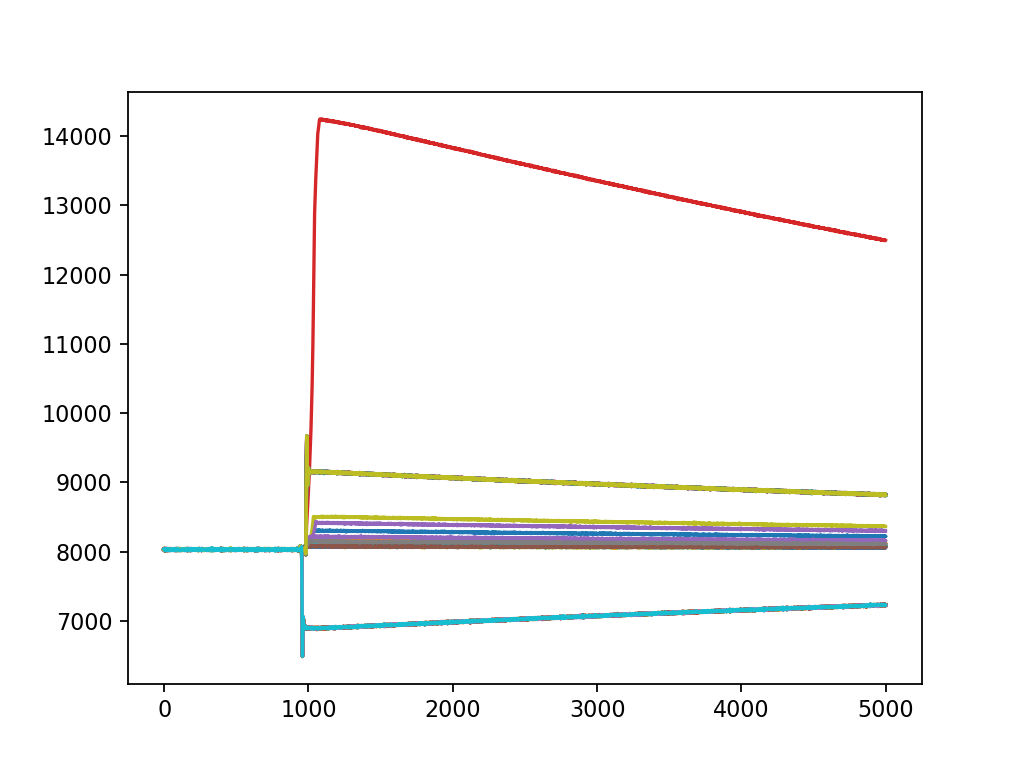

In [6]:
# plot pulser pulses
# number of random pulses
number_of_pulses = 100
plt.figure()
for i in range(number_of_pulses):
    n = int(np.random.rand()*len(noise))
    plt.plot(noise[n])
#plt.xlim(920,1150)
plt.show()

In [7]:
# save as tau for filter
#tau = tau_fixed.mean()
tau = 10967.425786005182
tau = tau * 4 * 10**(-9)

peaking_time = 110 * 4 * 10**(-9)#1.6e-6/2
#peaking_time = 100 * 4 * 10**(-9) * 10
gap_time = peaking_time * 5  #6.4e-6/4

tau, peaking_time, gap_time

(4.3869703144020734e-05, 4.4e-07, 2.2e-06)

In [8]:
# Jordanov_filter = JordanovFilter(peaking_time, gap_time, tau)
# Bogovac_filter = BogovacFilter(peaking_time, gap_time, tau)
Cooper_filter = CooperFilter(peaking_time, gap_time, tau)

In [10]:
filtered_noise = Cooper_filter.filter_waveform(noise,normalize=True)

In [13]:
noise_spec = spectrum(filtered_noise,bins=2000,quantile=0.996)

<IPython.core.display.Javascript object>


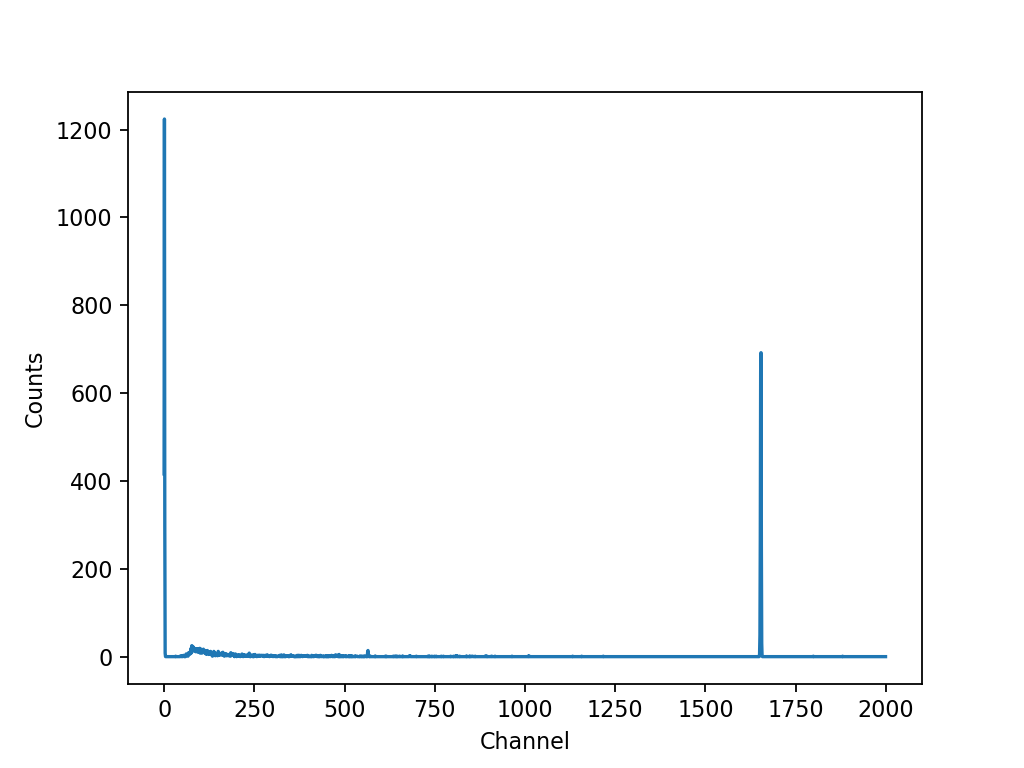

In [14]:
noise_spec.plot_spectrum(energy=False,show_calibrated_peaks=False)

Finding Peaks


<IPython.core.display.Javascript object>


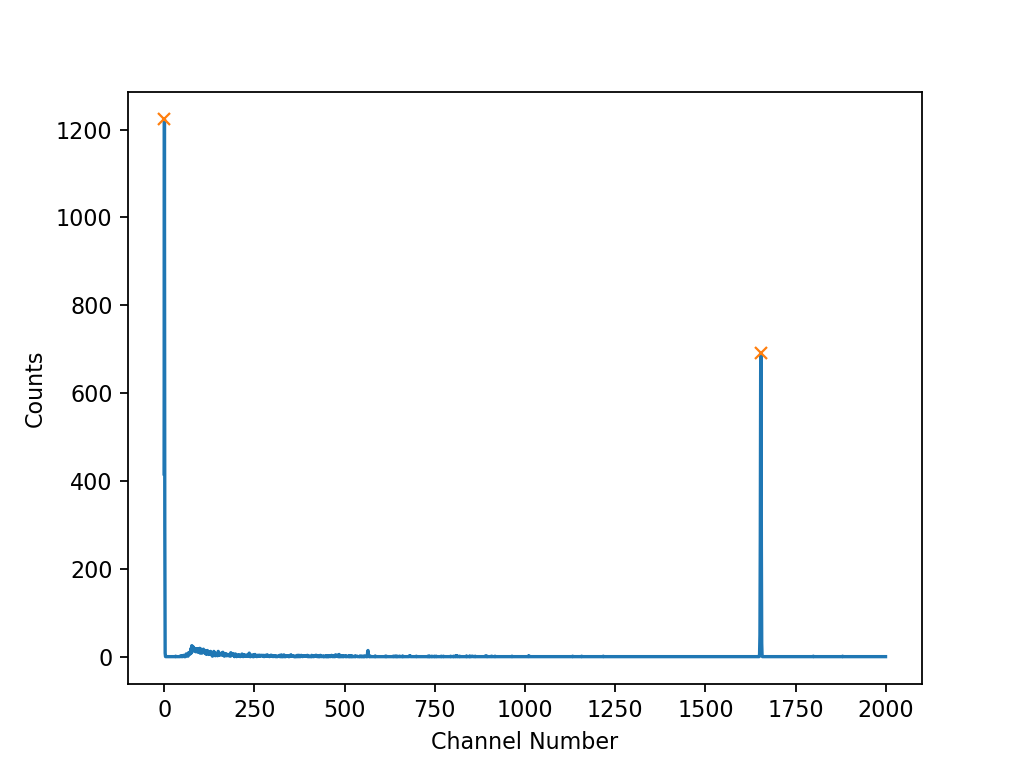

In [28]:
noise_spec.find_gamma_peaks(show_plot=True,prominence=100)
# delete low energy noise peak
noise_spec.peaks = np.delete(noise_spec.peaks,0)

In [30]:
noise_spec.peaks

array([1654])

In [40]:
Ewind = 10
# find fwhm in units of channels
centroid = noise_spec.peaks[0]
roi_x = noise_spec.channels[centroid - Ewind: centroid + Ewind]
roi_y = noise_spec.counts[centroid -Ewind: centroid + Ewind]
popt_gauss, pcov_gaus = curve_fit(gaussian, roi_x, roi_y, [noise_spec.counts[centroid],noise_spec.channels[centroid],np.sqrt(noise_spec.counts[centroid])])

In [41]:
popt_gauss

array([ 7.54877413e+02,  1.65350909e+03, -1.02729657e+00])

In [43]:
# multiply by energy calibration slope to convert to energy
# see main analysis notebook for slope value given below
sigma_E_noise = abs(popt_gauss[2]) * 1.1237715757566327

In [44]:
noise_fwhm = abs(sigma_E_noise*2.355)
noise_counts = roi_y.sum()

In [45]:
noise_fwhm

2.7187219507156715